# 📦 Dependencies

In [1]:
%pip install tensorflow==2.16.2
#    If I don't force the tensorflow version, notebook environments
#      like Google Colaboratory will break since they used an outdated 
#      version currently. I've tested this on a handful of notebook
#      environments, and this seems to be the only version-specific package
#      that needs to be enforced.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import subprocess
import sys
import os

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import sklearn
    print("scikit-learn is already installed.")
except ImportError:
    install("scikit-learn")
    import sklearn
    print("scikit-learn has been installed.")

try:
    from tqdm import tqdm
    print("tqdm is already installed.")
except ImportError:
    install("tqdm")
    from tqdm import tqdm
    print("tqdm has been installed.")

scikit-learn is already installed.
tqdm is already installed.


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
notebookStart = time.time()

# 🚧 File Importing

## Schema

This dataset contains a number of files which are not relevant to this project. By reviewing each one I determined what files should actually be used.

In [5]:
fileNames = ['adult.data',
'adult.names',
'adult.test',
'Index',
'old.adult.names']

In [6]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country",
    "income"
]

Above are all the listed file names, but only "adult.data" contains anything useful to us. We'll slice this list down when we go to import the data as a result.

Let's import then take a look at the top 5 rows just to make sure everything appears orderly.

In [7]:
file_path = "data/" + fileNames[0]

dataOrigin = pd.read_csv(file_path, header=None, names=column_names)

dataOrigin.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Looks like the data imported cleanly, and the column headers seem reasonable with the data that displays. Let's proceed.

# 🔍 Exploratory Data Analysis

## Class Imbalance

The first question I have is, 'how imbalanced is this dataset'? Lets see what the ratio of the class label looks like.

In [8]:
count_greater_than = dataOrigin['income'].str.contains('>').sum()

percentage_greater_than = (count_greater_than / len(dataOrigin)) * 100

print(f"Affirmative class label: {percentage_greater_than:.2f}%")

Affirmative class label: 24.08%


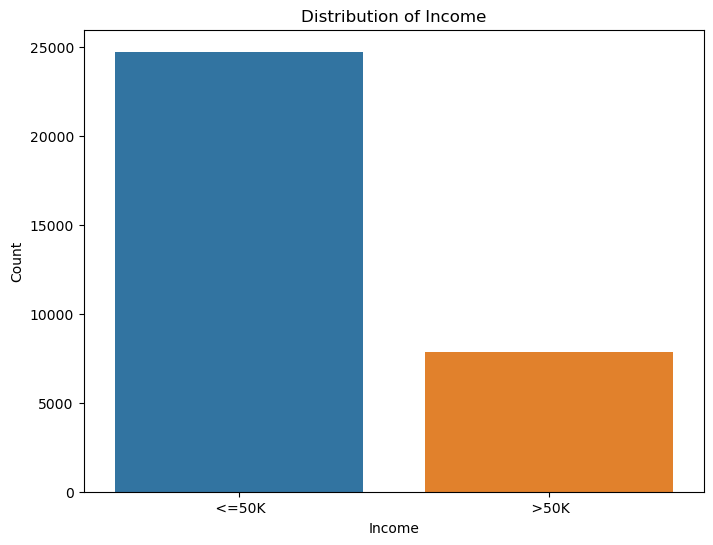

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='income', data=dataOrigin)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

## Numerical Correlations

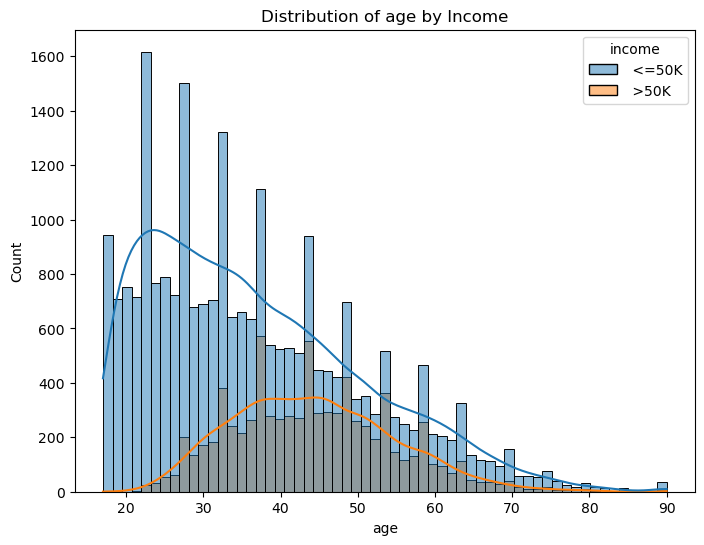

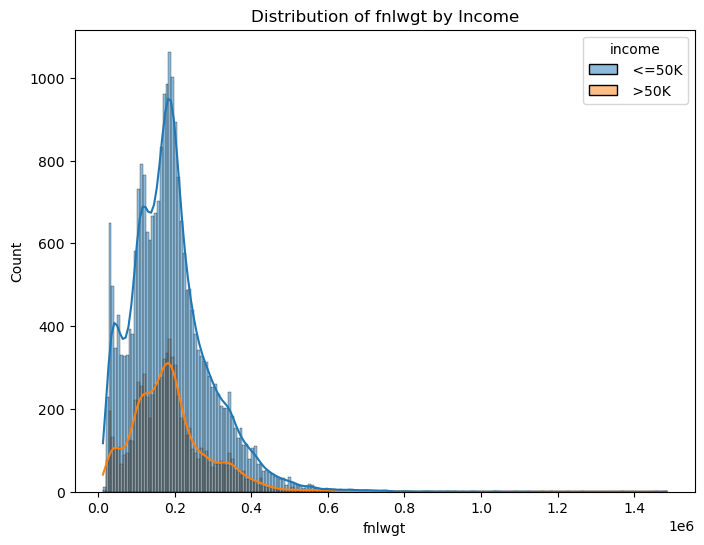

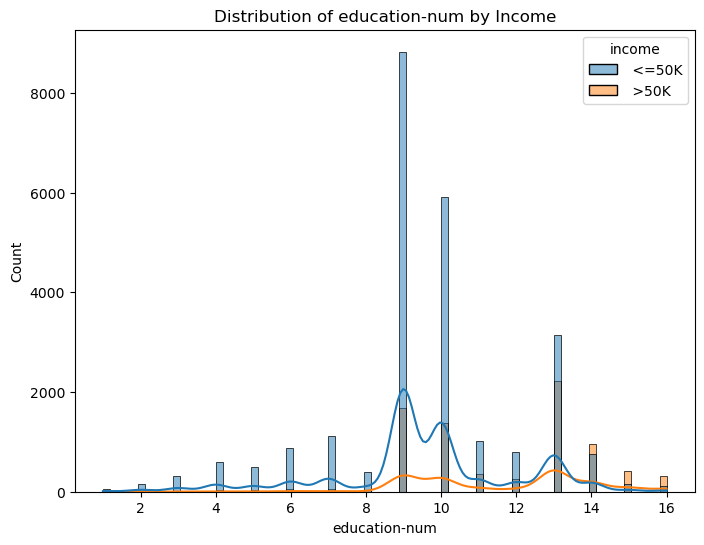

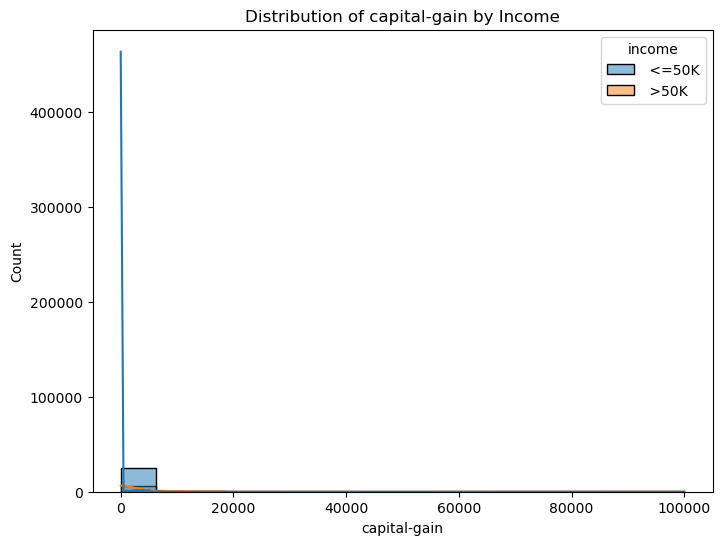

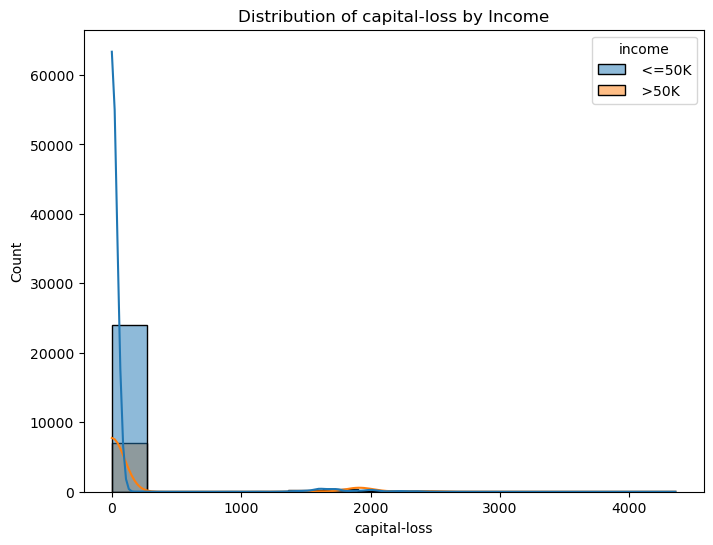

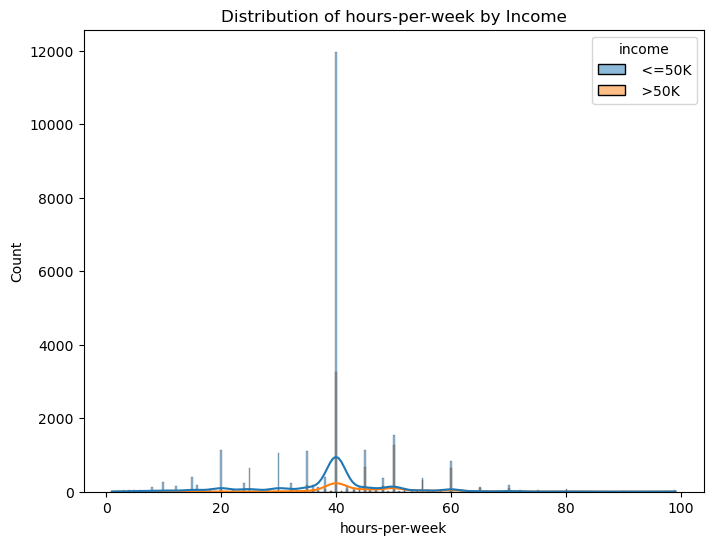

In [10]:
numerical_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=dataOrigin, x=feature, hue='income', kde=True)
    plt.title(f'Distribution of {feature} by Income')
    plt.show()


## Categorical Correlations

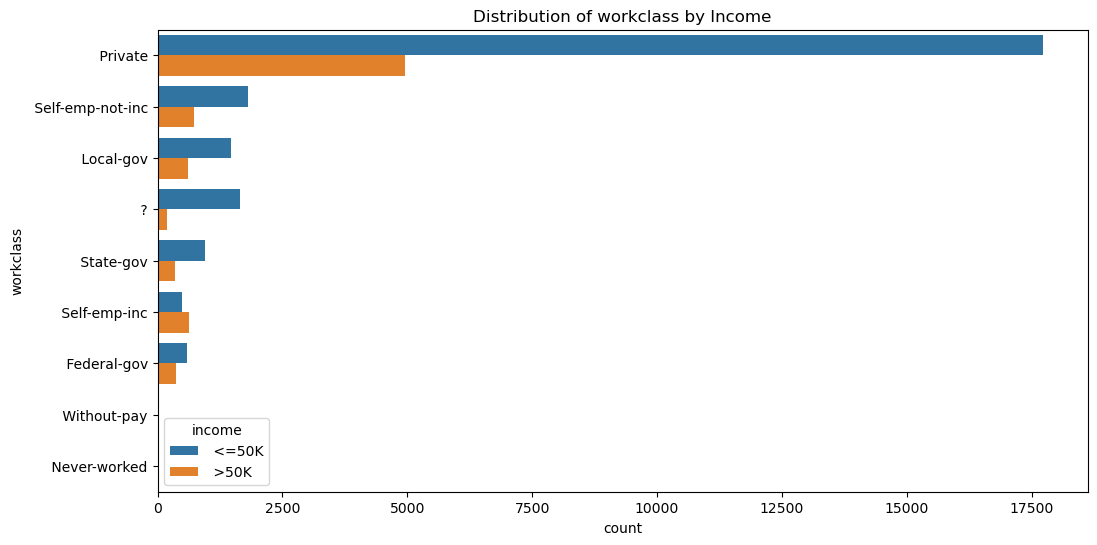

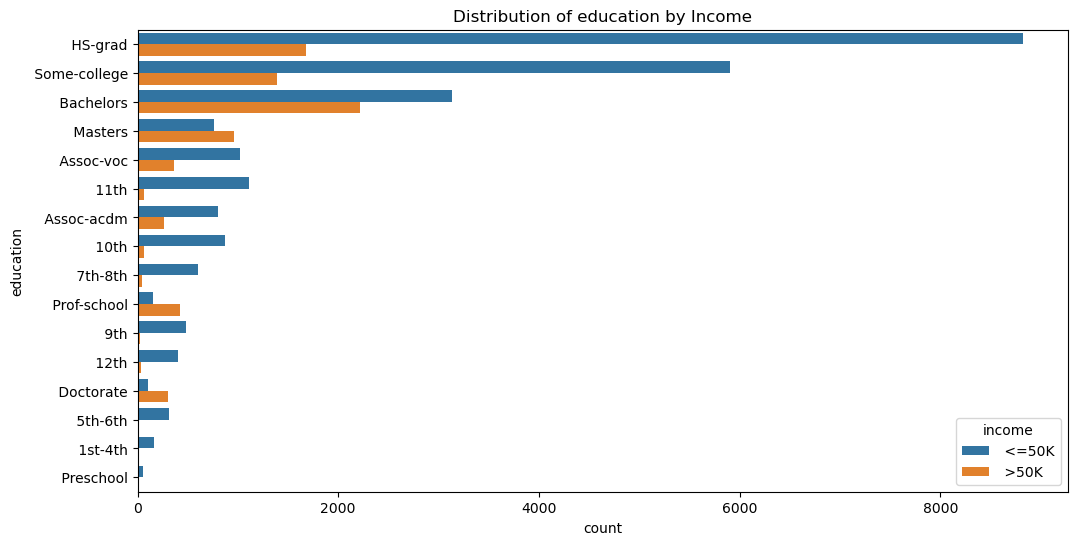

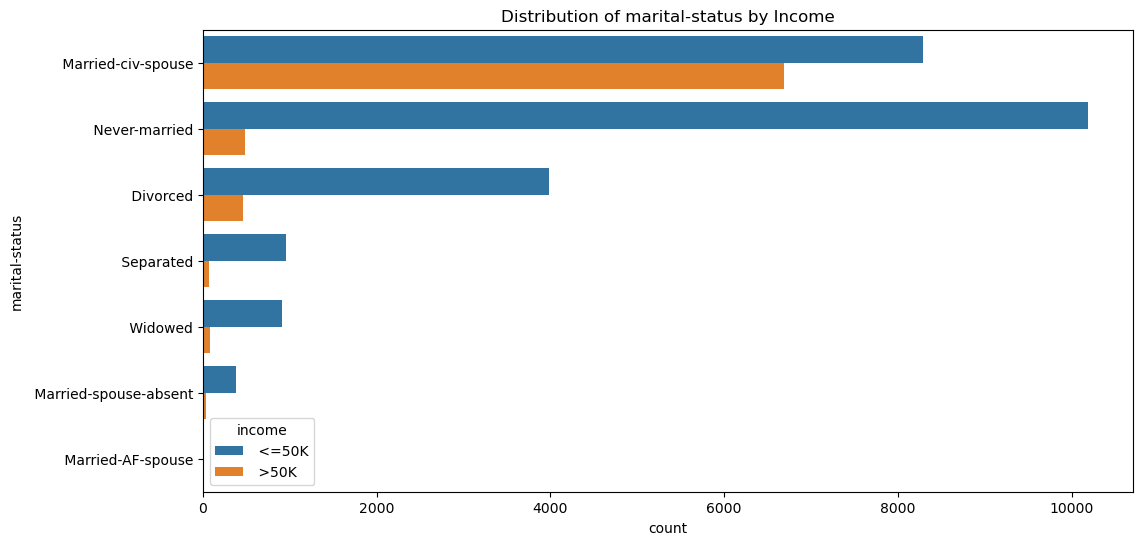

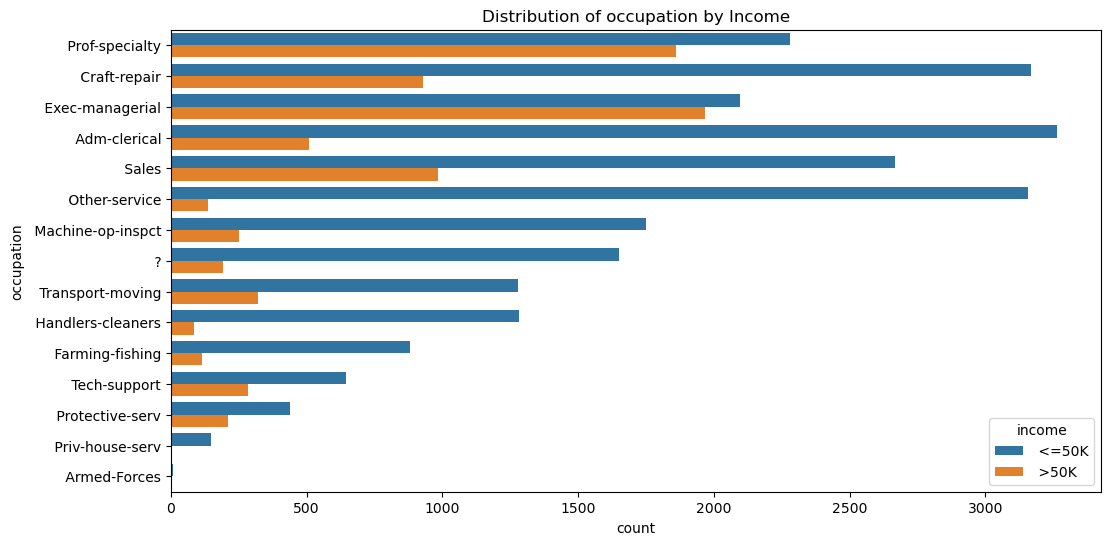

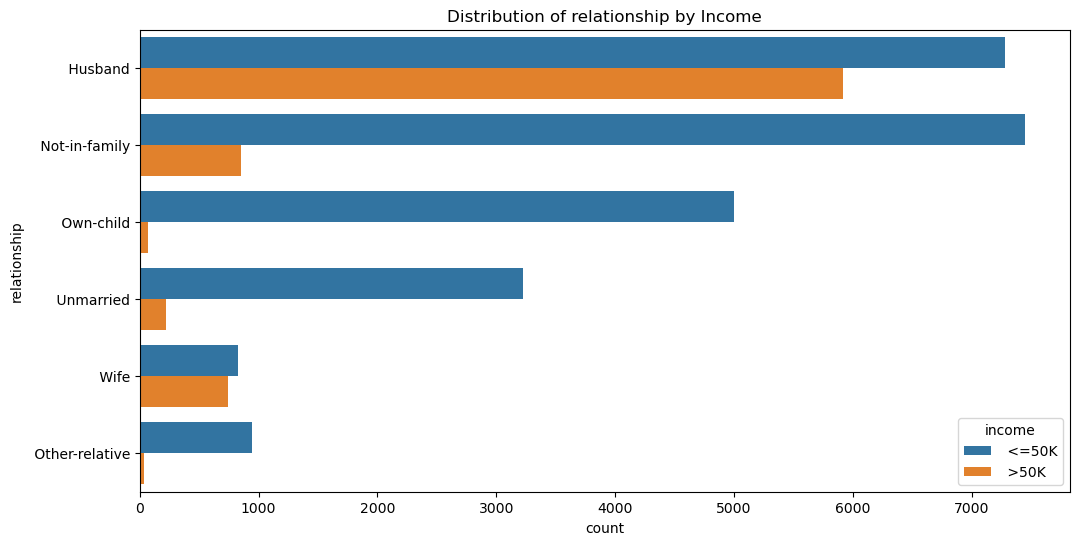

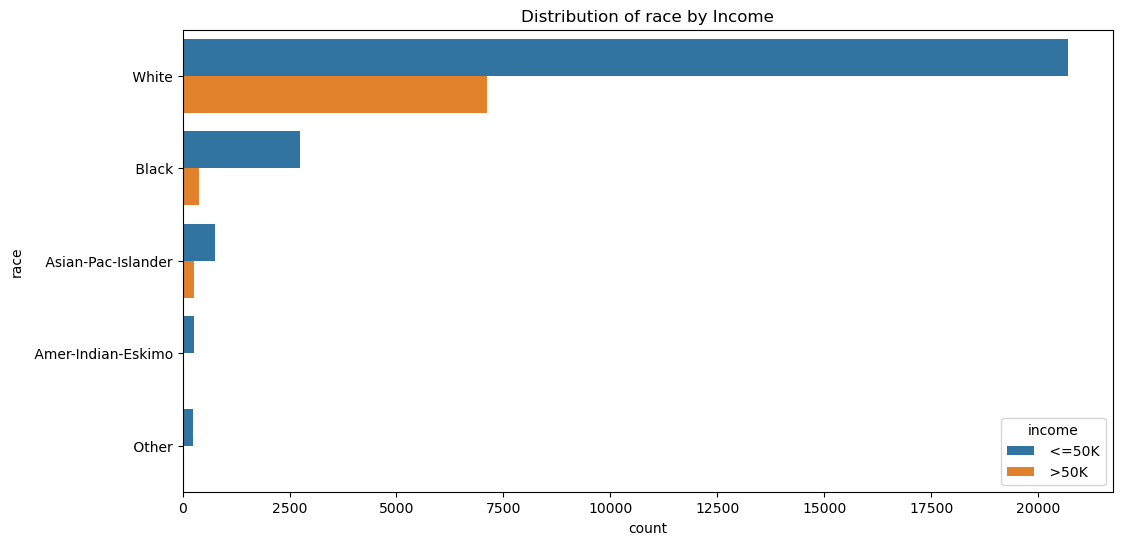

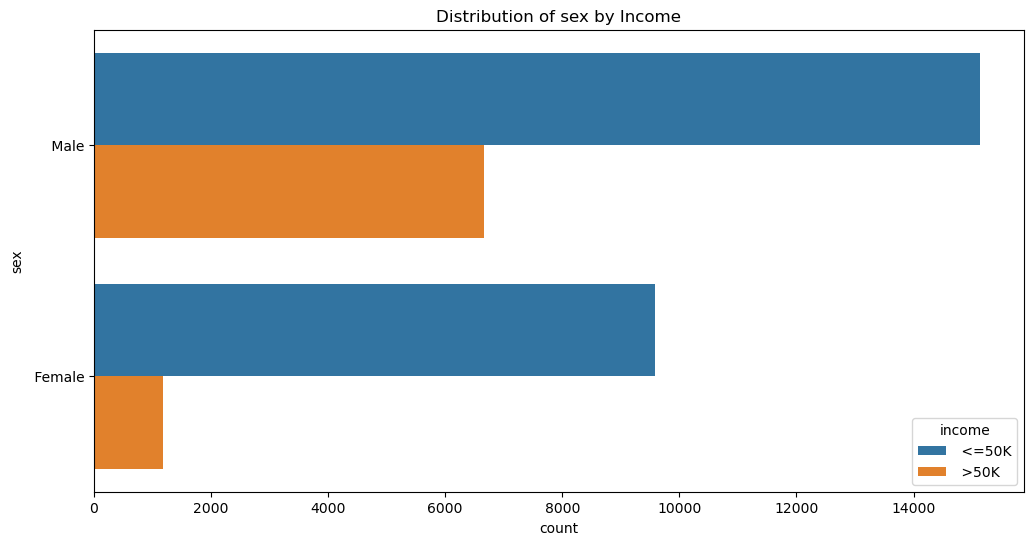

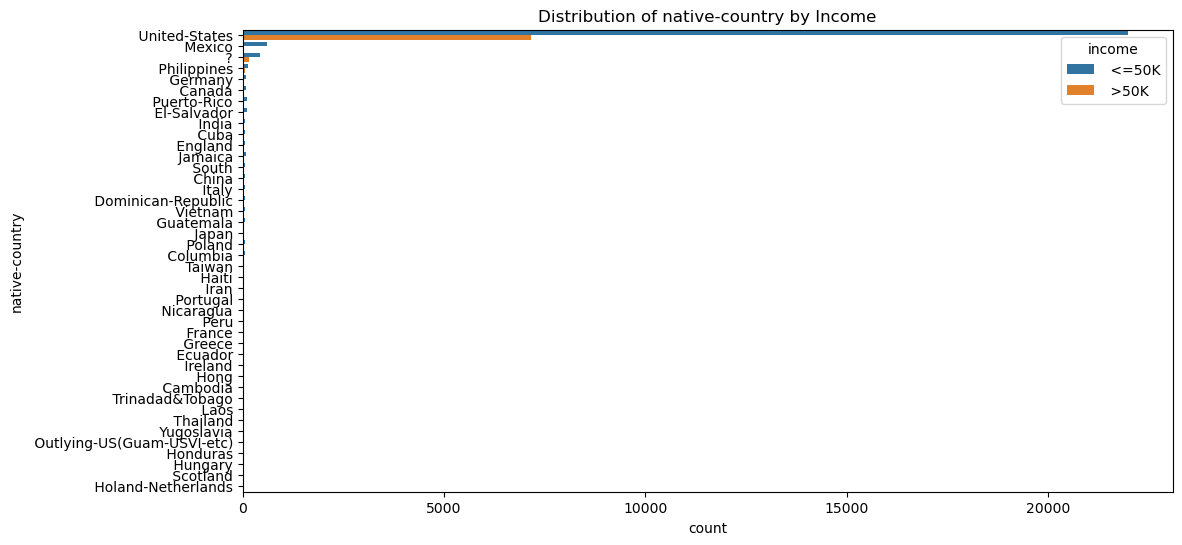

In [11]:
categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(y=feature, hue='income', data=dataOrigin, order=dataOrigin[feature].value_counts().index)
    plt.title(f'Distribution of {feature} by Income')
    plt.show()


## Correlation Matrix

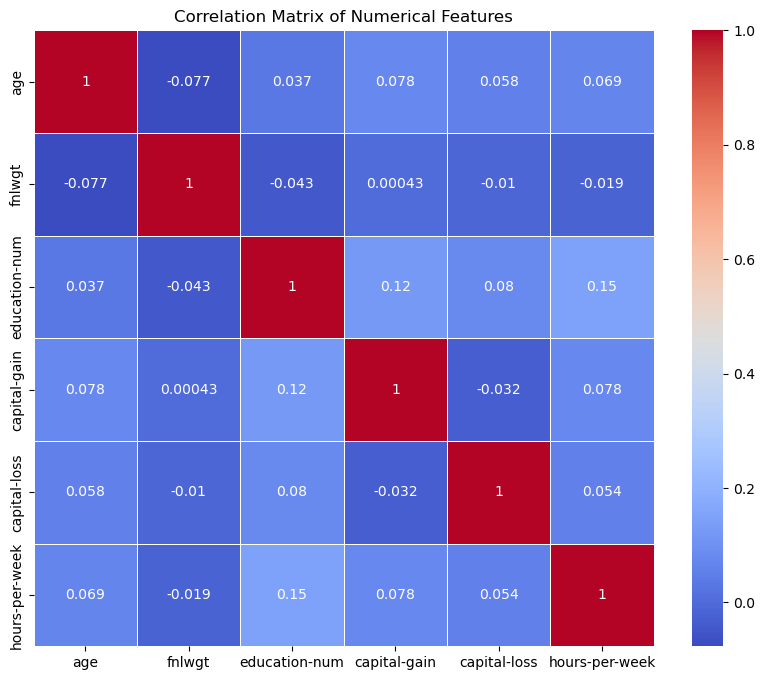

In [12]:
correlation_matrix = dataOrigin[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


From this exploratory data analysis, I think a fair hypothesis is that this model will probably lean heavily on attributes which represent:
* Education
* Marital Status
* Race
* Sex

# 🏭 Pre-processing

Lot's of features, and quite a few categorical ones. We'll need to identify those for pre-processing.

In [13]:
dataOrigin.select_dtypes(exclude=['number']).columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')

Sex & income are both bools, but income is really our target so we don't need to worry as much about that. We'll encode that to 1 or 0 on our own.

In [14]:
dataOrigin['income_target'] = dataOrigin['income'].apply(lambda x: 1 if '>' in str(x) else 0)

In [15]:
dataOrigin.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,income_target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K,0
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K,1


Lets remove the original income column since it's no longer needed.

In [16]:
dataOrigin.drop(columns=['income'], inplace=True)
dataOrigin.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income_target'],
      dtype='object')

Let's perform all of the data handling steps before we begin doing our modeling. I want to be able to pass each model the same dataset in without any additional steps after we begin the initial training.  

We'll make a copy of our dataOrigin dataframe to preserve the original content in case we need to compare later.

In [17]:
df = dataOrigin.copy()

In [18]:
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                     'capital-loss', 'hours-per-week']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])


# 🌎 Model Architecture

## LSTM

In [19]:
class ReshapeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.toarray().reshape((X.shape[0], X.shape[1], 1))

def create_lstm_model(input_dim):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim, 1)))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

class KerasLSTMWrapper:
    def __init__(self, input_dim, epochs=10, batch_size=64):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
    
    def fit(self, X, y):
        self.model = create_lstm_model(self.input_dim)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        predictions = self.model.predict(X)
        return (predictions > 0.5).astype(int)

X = df.drop('income_target', axis=1)
y = df['income_target']

lstm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reshape', ReshapeTransformer()),
    ('classifier', KerasLSTMWrapper(input_dim=len(X.columns)))
])

## Random Forest

In [20]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=150, 
        criterion='gini', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0,
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0, 
        bootstrap=True, 
        oob_score=False, 
        n_jobs=None, 
        random_state=71, 
        verbose=0, 
        warm_start=False, 
        class_weight=None, 
        ccp_alpha=0.0, 
        max_samples=None
    ))
])

## K-Nearest Neighbors

In [21]:
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(
        n_neighbors=7,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=2,
        metric='minkowski',
        metric_params=None,
        n_jobs=None
    ))
])


## Cross Validation Parameters

In [22]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)

# 🏋️‍♀️ Model Training

## Classifier dictionary

In [23]:
classifiers = {
    'LSTM': lstm_model,
    'RandomForest': rf_model,
    'KNeighbors': knn_model
}

metrics_dict = {classifier: {'accuracies': [],
                             'precisions': [],
                             'recalls': [],
                             'f1_scores': [],
                             'fprs': [],
                             'fnrs': [],
                             'tps': [],
                             'tns': [],
                             'fps': [],
                             'fns': [],
                             'tss_list': [],
                             'hss_list': []
                            } for classifier in classifiers}

## Fold-level Metric Calculations

In [24]:
for classifier_name, model in classifiers.items():
    print(f"\nClassifier: {classifier_name}")
    for train_index, test_index in tqdm(kf.split(X, y), total=kf.get_n_splits(), desc='Folds'):
        start_time = time.time()
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
        tss = (tp / (tp + fn)) - (fp / (fp + tn))
        hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
        
        metrics_dict[classifier_name]['accuracies'].append(accuracy)
        metrics_dict[classifier_name]['precisions'].append(precision)
        metrics_dict[classifier_name]['recalls'].append(recall)
        metrics_dict[classifier_name]['f1_scores'].append(f1)
        metrics_dict[classifier_name]['fprs'].append(fpr)
        metrics_dict[classifier_name]['fnrs'].append(fnr)
        metrics_dict[classifier_name]['tps'].append(tp)
        metrics_dict[classifier_name]['tns'].append(tn)
        metrics_dict[classifier_name]['fps'].append(fp)
        metrics_dict[classifier_name]['fns'].append(fn)
        metrics_dict[classifier_name]['tss_list'].append(tss)
        metrics_dict[classifier_name]['hss_list'].append(hss)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Fold completed in {elapsed_time:.2f} seconds | TPs: {tp} | FPs: {fp} | TNs: {tn} | FNs: {fn}")


Classifier: LSTM


Folds:   0%|          | 0/10 [00:00<?, ?it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


Folds:  10%|█         | 1/10 [03:04<27:39, 184.36s/it]

Fold completed in 184.35 seconds | TPs: 0 | FPs: 0 | TNs: 2472 | FNs: 785
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Folds:  20%|██        | 2/10 [06:14<25:00, 187.59s/it]

Fold completed in 189.86 seconds | TPs: 0 | FPs: 0 | TNs: 2472 | FNs: 784
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Folds:  30%|███       | 3/10 [09:24<22:02, 188.98s/it]

Fold completed in 190.64 seconds | TPs: 0 | FPs: 0 | TNs: 2472 | FNs: 784
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Folds:  40%|████      | 4/10 [12:33<18:54, 189.00s/it]

Fold completed in 189.03 seconds | TPs: 0 | FPs: 0 | TNs: 2472 | FNs: 784
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Folds:  50%|█████     | 5/10 [15:47<15:52, 190.57s/it]

Fold completed in 193.34 seconds | TPs: 0 | FPs: 0 | TNs: 2472 | FNs: 784
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Folds:  60%|██████    | 6/10 [19:08<12:56, 194.19s/it]

Fold completed in 201.21 seconds | TPs: 0 | FPs: 0 | TNs: 2472 | FNs: 784
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Folds:  70%|███████   | 7/10 [22:21<09:41, 193.84s/it]

Fold completed in 193.13 seconds | TPs: 103 | FPs: 46 | TNs: 2426 | FNs: 681
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Folds:  80%|████████  | 8/10 [25:27<06:22, 191.34s/it]

Fold completed in 186.00 seconds | TPs: 1 | FPs: 0 | TNs: 2472 | FNs: 783
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Folds:  90%|█████████ | 9/10 [28:36<03:10, 190.63s/it]

Fold completed in 189.06 seconds | TPs: 44 | FPs: 16 | TNs: 2456 | FNs: 740
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Folds: 100%|██████████| 10/10 [31:43<00:00, 190.36s/it]


Fold completed in 186.94 seconds | TPs: 10 | FPs: 5 | TNs: 2467 | FNs: 774

Classifier: RandomForest


Folds:  10%|█         | 1/10 [00:31<04:44, 31.66s/it]

Fold completed in 31.66 seconds | TPs: 488 | FPs: 193 | TNs: 2279 | FNs: 297


Folds:  20%|██        | 2/10 [01:03<04:12, 31.54s/it]

Fold completed in 31.45 seconds | TPs: 493 | FPs: 194 | TNs: 2278 | FNs: 291


Folds:  30%|███       | 3/10 [01:35<03:41, 31.70s/it]

Fold completed in 31.90 seconds | TPs: 475 | FPs: 191 | TNs: 2281 | FNs: 309


Folds:  40%|████      | 4/10 [02:05<03:07, 31.31s/it]

Fold completed in 30.70 seconds | TPs: 493 | FPs: 178 | TNs: 2294 | FNs: 291


Folds:  50%|█████     | 5/10 [02:36<02:35, 31.10s/it]

Fold completed in 30.74 seconds | TPs: 507 | FPs: 168 | TNs: 2304 | FNs: 277


Folds:  60%|██████    | 6/10 [03:07<02:04, 31.16s/it]

Fold completed in 31.27 seconds | TPs: 491 | FPs: 179 | TNs: 2293 | FNs: 293


Folds:  70%|███████   | 7/10 [03:39<01:34, 31.49s/it]

Fold completed in 32.16 seconds | TPs: 496 | FPs: 178 | TNs: 2294 | FNs: 288


Folds:  80%|████████  | 8/10 [04:11<01:02, 31.47s/it]

Fold completed in 31.45 seconds | TPs: 478 | FPs: 157 | TNs: 2315 | FNs: 306


Folds:  90%|█████████ | 9/10 [04:43<00:31, 31.57s/it]

Fold completed in 31.77 seconds | TPs: 491 | FPs: 183 | TNs: 2289 | FNs: 293


Folds: 100%|██████████| 10/10 [05:13<00:00, 31.38s/it]


Fold completed in 30.65 seconds | TPs: 498 | FPs: 190 | TNs: 2282 | FNs: 286

Classifier: KNeighbors


Folds:  10%|█         | 1/10 [00:03<00:29,  3.27s/it]

Fold completed in 3.27 seconds | TPs: 460 | FPs: 239 | TNs: 2233 | FNs: 325


Folds:  20%|██        | 2/10 [00:06<00:25,  3.22s/it]

Fold completed in 3.19 seconds | TPs: 480 | FPs: 230 | TNs: 2242 | FNs: 304


Folds:  30%|███       | 3/10 [00:09<00:22,  3.22s/it]

Fold completed in 3.21 seconds | TPs: 459 | FPs: 239 | TNs: 2233 | FNs: 325


Folds:  40%|████      | 4/10 [00:12<00:19,  3.25s/it]

Fold completed in 3.30 seconds | TPs: 477 | FPs: 218 | TNs: 2254 | FNs: 307


Folds:  50%|█████     | 5/10 [00:16<00:16,  3.23s/it]

Fold completed in 3.19 seconds | TPs: 489 | FPs: 213 | TNs: 2259 | FNs: 295


Folds:  60%|██████    | 6/10 [00:19<00:12,  3.20s/it]

Fold completed in 3.14 seconds | TPs: 462 | FPs: 216 | TNs: 2256 | FNs: 322


Folds:  70%|███████   | 7/10 [00:22<00:09,  3.20s/it]

Fold completed in 3.19 seconds | TPs: 504 | FPs: 227 | TNs: 2245 | FNs: 280


Folds:  80%|████████  | 8/10 [00:25<00:06,  3.22s/it]

Fold completed in 3.28 seconds | TPs: 464 | FPs: 213 | TNs: 2259 | FNs: 320


Folds:  90%|█████████ | 9/10 [00:28<00:03,  3.20s/it]

Fold completed in 3.15 seconds | TPs: 465 | FPs: 236 | TNs: 2236 | FNs: 319


Folds: 100%|██████████| 10/10 [00:32<00:00,  3.22s/it]

Fold completed in 3.22 seconds | TPs: 472 | FPs: 217 | TNs: 2255 | FNs: 312


# 👨‍⚖️ Model Evaluation

In [25]:
foldDict = {}
for i in metrics_dict.keys():
    foldDict[i] = pd.DataFrame(metrics_dict[i])

### LSTM

In [26]:
foldDict['LSTM']

,accuracies,precisions,recalls,f1_scores,fprs,fnrs,tps,tns,fps,fns,tss_list,hss_list
0,0.758981,0.000000,0.000000,0.000000,0.000000,1.000000,0,2472,0,785,0.000000,0.000000
1,0.759214,0.000000,0.000000,0.000000,0.000000,1.000000,0,2472,0,784,0.000000,0.000000
2,0.759214,0.000000,0.000000,0.000000,0.000000,1.000000,0,2472,0,784,0.000000,0.000000
3,0.759214,0.000000,0.000000,0.000000,0.000000,1.000000,0,2472,0,784,0.000000,0.000000
4,0.759214,0.000000,0.000000,0.000000,0.000000,1.000000,0,2472,0,784,0.000000,0.000000
5,0.759214,0.000000,0.000000,0.000000,0.000000,1.000000,0,2472,0,784,0.000000,0.000000
6,0.776720,0.691275,0.131378,0.220793,0.018608,0.868622,103,2426,46,681,0.112769,0.155874
7,0.759521,1.000000,0.001276,0.002548,0.000000,0.998724,1,2472,0,783,0.001276,0.001935
8,0.767813,0.733333,0.056122,0.104265,0.006472,0.943878,44,2456,16,740,0.049650,0.072513
9,0.760749,0.666667,0.012755,0.025031,0.002023,0.987245,10,2467,5,774,0.010732,0.016136


### Random Forest

In [27]:
foldDict['RandomForest']

,accuracies,precisions,recalls,f1_scores,fprs,fnrs,tps,tns,fps,fns,tss_list,hss_list
0,0.849555,0.716593,0.621656,0.665757,0.078074,0.378344,488,2279,193,297,0.543582,0.569318
1,0.851044,0.717613,0.628827,0.670292,0.078479,0.371173,493,2278,194,291,0.550348,0.574621
2,0.846437,0.713213,0.605867,0.655172,0.077265,0.394133,475,2281,191,309,0.528602,0.557237
3,0.855958,0.734724,0.628827,0.677663,0.072006,0.371173,493,2294,178,291,0.556820,0.585640
4,0.863329,0.751111,0.646684,0.694997,0.067961,0.353316,507,2304,168,277,0.578723,0.607563
5,0.855037,0.732836,0.626276,0.675378,0.072411,0.373724,491,2293,179,293,0.553865,0.582798
6,0.856880,0.735905,0.632653,0.680384,0.072006,0.367347,496,2294,178,288,0.560647,0.588855
7,0.857801,0.752756,0.609694,0.673714,0.063511,0.390306,478,2315,157,306,0.546183,0.584082
8,0.853808,0.728487,0.626276,0.673525,0.074029,0.373724,491,2289,183,293,0.552246,0.580032
9,0.853808,0.723837,0.635204,0.676630,0.076861,0.364796,498,2282,190,286,0.558343,0.582704


### K-Nearest Neighbors

In [28]:
foldDict['KNeighbors']

,accuracies,precisions,recalls,f1_scores,fprs,fnrs,tps,tns,fps,fns,tss_list,hss_list
0,0.826835,0.658083,0.585987,0.619946,0.096683,0.414013,460,2233,239,325,0.489304,0.508306
1,0.835995,0.676056,0.612245,0.642570,0.093042,0.387755,480,2242,230,304,0.519203,0.536492
2,0.826781,0.657593,0.585459,0.619433,0.096683,0.414541,459,2233,239,325,0.488776,0.507794
3,0.838759,0.686331,0.608418,0.645030,0.088188,0.391582,477,2254,218,307,0.520231,0.541207
4,0.843980,0.696581,0.623724,0.658143,0.086165,0.376276,489,2259,213,295,0.537559,0.557467
5,0.834767,0.681416,0.589286,0.632011,0.087379,0.410714,462,2256,216,322,0.501907,0.526197
6,0.844287,0.689466,0.642857,0.665347,0.091828,0.357143,504,2245,227,280,0.551029,0.564047
7,0.836302,0.685377,0.591837,0.635181,0.086165,0.408163,464,2259,213,320,0.505672,0.530386
8,0.829545,0.663338,0.593112,0.626263,0.095469,0.406888,465,2236,236,319,0.497643,0.516305
9,0.837531,0.685051,0.602041,0.640869,0.087783,0.397959,472,2255,217,312,0.514258,0.536451


### Export Fold-level Metrics

In [29]:
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save each DataFrame to a CSV file
for key in foldDict.keys():
    foldDict[key].to_csv(f"{output_dir}/{key}_fold_metrics.csv", index=False)

In [30]:
for key in foldDict.keys():
    foldDict[key].to_csv(f"output/{key}_fold_metrics.csv", index = False)

## Aggregate Results (Mean)

In [31]:
results = []

for classifier_name, metrics in metrics_dict.items():
    mean_accuracy = np.mean(metrics['accuracies'])
    mean_precision = np.mean(metrics['precisions'])
    mean_recall = np.mean(metrics['recalls'])
    mean_f1 = np.mean(metrics['f1_scores'])
    mean_fpr = np.mean(metrics['fprs'])
    mean_fnr = np.mean(metrics['fnrs'])
    mean_tss = np.mean(metrics['tss_list'])
    mean_hss = np.mean(metrics['hss_list'])
    mean_tp = np.mean(metrics['tps'])
    mean_tn = np.mean(metrics['tns'])
    mean_fp = np.mean(metrics['fps'])
    mean_fn = np.mean(metrics['fns'])
    
    results.append({
        'Classifier': classifier_name,
        'TP': mean_tp,
        'TN': mean_tn,
        'FP': mean_fp,
        'FN': mean_fn,
        'Accuracy': mean_accuracy,
        'Precision': mean_precision,
        'Recall': mean_recall,
        'F1 Score': mean_f1,
        'FPR': mean_fpr,
        'FNR': mean_fnr,
        'TSS': mean_tss,
        'HSS': mean_hss
    })

results_df = pd.DataFrame(results)
results_df

,Classifier,TP,TN,FP,FN,Accuracy,Precision,Recall,F1 Score,FPR,FNR,TSS,HSS
0,LSTM,15.8,2465.3,6.7,768.3,0.761985,0.309128,0.020153,0.035264,0.002710,0.979847,0.017443,0.024646
1,RandomForest,491.0,2290.9,181.1,293.1,0.854366,0.730708,0.626196,0.674351,0.073261,0.373804,0.552936,0.581285
2,KNeighbors,473.2,2247.2,224.8,310.9,0.835478,0.677929,0.603497,0.638479,0.090939,0.396503,0.512558,0.532465


In [32]:
results_df.to_csv(f"output/aggregate_metrics.csv", index = False)

## Feature Importances

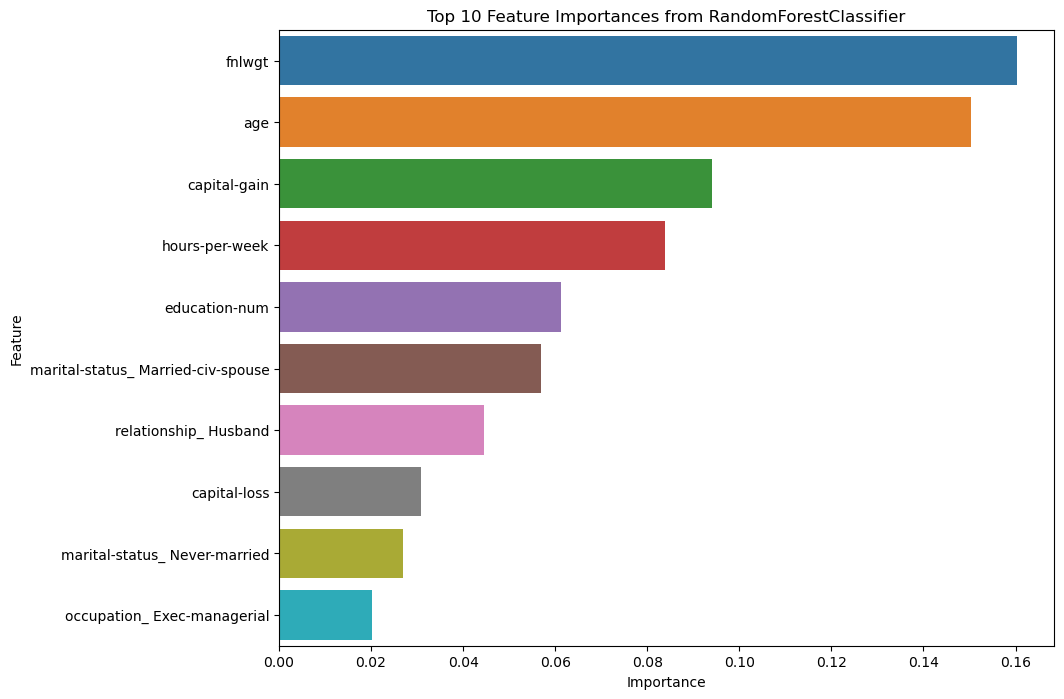

In [33]:
feature_importances = rf_model.named_steps['classifier'].feature_importances_

onehot_features = rf_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_columns)
all_feature_names = numerical_columns + list(onehot_features)

feature_importances_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

top_10_features_df = feature_importances_df.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_10_features_df, x='importance', y='feature')
plt.title('Top 10 Feature Importances from RandomForestClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## K-Nearest Neighbors

# ⏰ Notebook Duration

In [34]:
notebookEnd = time.time()

In [35]:
notebookDuration = notebookEnd - notebookStart
f"{(notebookDuration / 60):.2f} minutes"

'37.60 minutes'